# EDA and Core Model Training for Class Suspension Prediction

**Purpose:** Comprehensive exploratory data analysis, feature selection, and model training on train+validation splits only

**Critical:** NEVER load test set in this notebook

**Structure:**
- Section 0: Setup & configuration
- Section 1: Exploratory data analysis
- Section 2: Feature selection & preparation
- Section 3-6: Baseline and advanced models
- Section 7: Threshold tuning
- Section 8: Model comparison & validation
- Section 9: Explainability
- Section 10: Save outputs & handover

**References:**
- notebook_02_complete_instructions.md
- 01_create_master_dataset.ipynb


## Section 0: Setup & Configuration


In [37]:
# Cell 0.1: Import Libraries and Constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path
import json

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve
)

# Imbalanced learning
from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier
)
from imblearn.over_sampling import SMOTE

# Tree models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Warning: SHAP not available")

# Neural networks
try:
    import tensorflow as tf
    from keras import layers, optimizers, losses, metrics, callbacks, regularizers
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("Warning: TensorFlow not available")

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if TENSORFLOW_AVAILABLE:
    tf.random.set_seed(RANDOM_SEED)

# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

# LOCATION_MAPPING from Notebook 01
LOCATION_MAPPING = {
    0: 'Manila', 1: 'Quezon City', 2: 'Caloocan', 3: 'Las Piñas',
    4: 'Makati', 5: 'Malabon', 6: 'Mandaluyong', 7: 'Marikina',
    8: 'Muntinlupa', 9: 'Navotas', 10: 'Parañaque', 11: 'Pasay',
    12: 'Pasig', 13: 'Pateros', 14: 'San Juan', 15: 'Taguig',
    16: 'Valenzuela'
}

print("✅ Libraries imported successfully")
print(f"Random seed: {RANDOM_SEED}")
print(f"SHAP available: {SHAP_AVAILABLE}")
print(f"TensorFlow available: {TENSORFLOW_AVAILABLE}")


✅ Libraries imported successfully
Random seed: 42
SHAP available: True
TensorFlow available: True


In [38]:
# Cell 0.2: Load Splits from Notebook 01
# CRITICAL: Load ONLY train and validation, NOT test set

train = pd.read_csv(PROCESSED_DIR / 'master_train.csv')
val = pd.read_csv(PROCESSED_DIR / 'master_validation.csv')

# Parse dates
train['date'] = pd.to_datetime(train['date'])
val['date'] = pd.to_datetime(val['date'])

print("✅ Train and Validation splits loaded")
print(f"\nTrain split:")
print(f"  Date range: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"  Rows: {len(train):,}")
print(f"  Suspensions: {train['suspension_occurred'].sum()} ({train['suspension_occurred'].mean():.2%})")

print(f"\nValidation split:")
print(f"  Date range: {val['date'].min().date()} to {val['date'].max().date()}")
print(f"  Rows: {len(val):,}")
print(f"  Suspensions: {val['suspension_occurred'].sum()} ({val['suspension_occurred'].mean():.2%})")

print(f"\n✅ All temporal lags present:")
lags_expected = ['hist_', 'fcst_', 'precip_sum_3d', 'precip_sum_7d', 'wind_max_7d']
found_lags = [col for col in train.columns if any(lag in col for lag in lags_expected)]
print(f"  Found {len(found_lags)} features with temporal lags")
print(f"  First 5: {found_lags[:5]}")


✅ Train and Validation splits loaded

Train split:
  Date range: 2022-08-22 to 2024-05-31
  Rows: 11,033
  Suspensions: 110 (1.00%)

Validation split:
  Date range: 2024-06-01 to 2024-11-30
  Rows: 3,111
  Suspensions: 201 (6.46%)

✅ All temporal lags present:
  Found 23 features with temporal lags
  First 5: ['hist_precipitation_sum_t1', 'hist_wind_speed_max_t1', 'hist_wind_gusts_max_t1', 'hist_pressure_msl_min_t1', 'hist_temperature_max_t1']


In [39]:
# Cell 0.3: Define Metric Functions
def compute_all_metrics(y_true, y_pred, y_proba=None):
    """
    Compute comprehensive metrics for binary classification.
    
    Returns:
        dict with TP, FP, FN, TN, Recall, Precision, Specificity, 
        F1, F2, G-Mean, PR-AUC
    """
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Core metrics
    recall = recall_score(y_true, y_pred) if tp + fn > 0 else 0.0
    precision = precision_score(y_true, y_pred) if tp + fp > 0 else 0.0
    specificity = tn / (tn + fp) if tn + fp > 0 else 0.0
    f1 = f1_score(y_true, y_pred)
    
    # F2 score (beta=2, emphasizes recall)
    f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if precision + recall > 0 else 0.0
    
    # G-Mean (geometric mean of sensitivity and specificity)
    g_mean = np.sqrt(recall * specificity) if recall * specificity > 0 else 0.0
    
    # PR-AUC
    pr_auc = average_precision_score(y_true, y_proba) if y_proba is not None else 0.0
    
    return {
        'TP': int(tp), 'FP': int(fp), 'FN': int(fn), 'TN': int(tn),
        'Recall': recall, 'Precision': precision, 'Specificity': specificity,
        'F1': f1, 'F2': f2, 'G-Mean': g_mean, 'PR-AUC': pr_auc
    }

# Initialize results list
results_list = []

print("✅ Metric functions defined")
print("Metrics computed: TP, FP, FN, TN, Recall, Precision, Specificity, F1, F2, G-Mean, PR-AUC")


✅ Metric functions defined
Metrics computed: TP, FP, FN, TN, Recall, Precision, Specificity, F1, F2, G-Mean, PR-AUC


## Section 1: Exploratory Data Analysis (Train + Val Only)


Class Distribution & Imbalance Summary:

Train split:
  Class 0 (No suspension): 10,923
  Class 1 (Suspension): 110
  Imbalance ratio: 99.3:1

Validation split:
  Class 0 (No suspension): 2,910
  Class 1 (Suspension): 201
  Imbalance ratio: 14.5:1


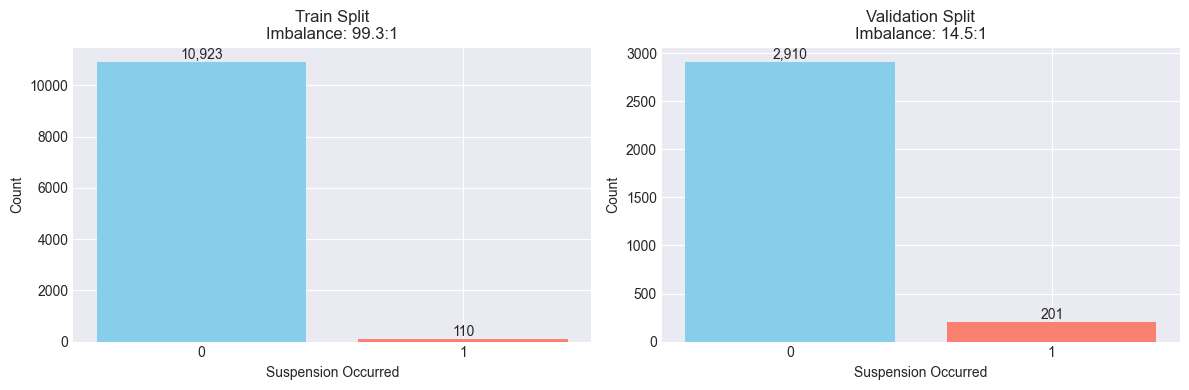


✅ Class distribution analysis complete


In [40]:
# Cell 1.1: Class Distribution & Imbalance Summary
from collections import Counter

# Count class distribution
train_counts = Counter(train['suspension_occurred'])
val_counts = Counter(val['suspension_occurred'])

train_imbalance = train_counts[0] / train_counts[1] if train_counts[1] > 0 else float('inf')
val_imbalance = val_counts[0] / val_counts[1] if val_counts[1] > 0 else float('inf')

print("Class Distribution & Imbalance Summary:")
print(f"\nTrain split:")
print(f"  Class 0 (No suspension): {train_counts[0]:,}")
print(f"  Class 1 (Suspension): {train_counts[1]:,}")
print(f"  Imbalance ratio: {train_imbalance:.1f}:1")

print(f"\nValidation split:")
print(f"  Class 0 (No suspension): {val_counts[0]:,}")
print(f"  Class 1 (Suspension): {val_counts[1]:,}")
print(f"  Imbalance ratio: {val_imbalance:.1f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
train_df = pd.DataFrame({'Class': [0, 1], 'Count': [train_counts[0], train_counts[1]]})
axes[0].bar(train_df['Class'], train_df['Count'], color=['skyblue', 'salmon'])
axes[0].set_title(f'Train Split\nImbalance: {train_imbalance:.1f}:1')
axes[0].set_xlabel('Suspension Occurred')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
for i, v in enumerate(train_df['Count']):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Validation
val_df = pd.DataFrame({'Class': [0, 1], 'Count': [val_counts[0], val_counts[1]]})
axes[1].bar(val_df['Class'], val_df['Count'], color=['skyblue', 'salmon'])
axes[1].set_title(f'Validation Split\nImbalance: {val_imbalance:.1f}:1')
axes[1].set_xlabel('Suspension Occurred')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
for i, v in enumerate(val_df['Count']):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Class distribution analysis complete")


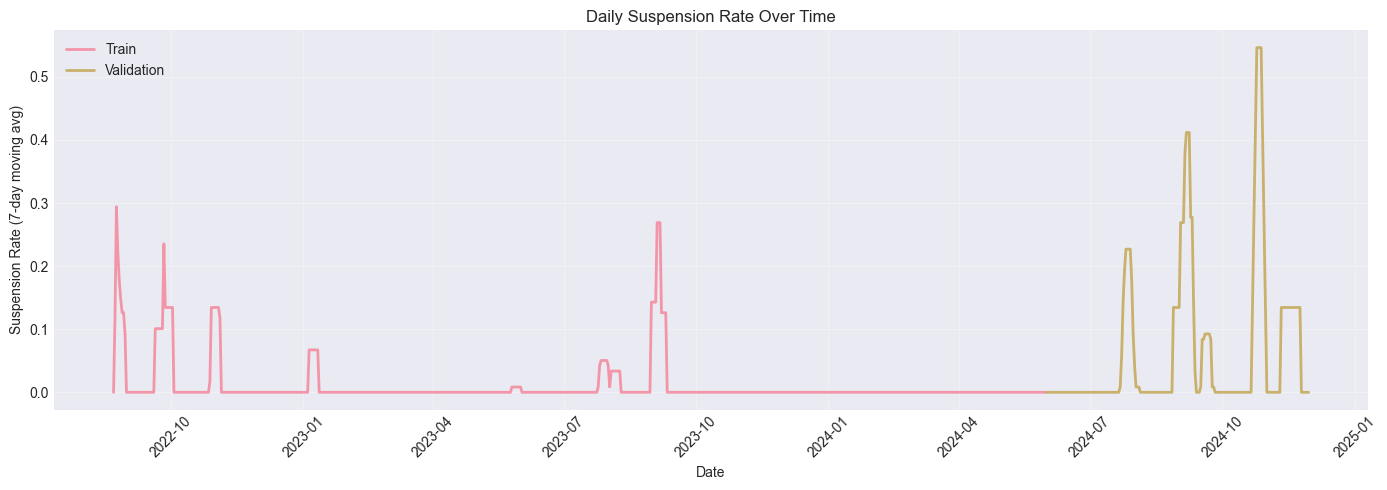

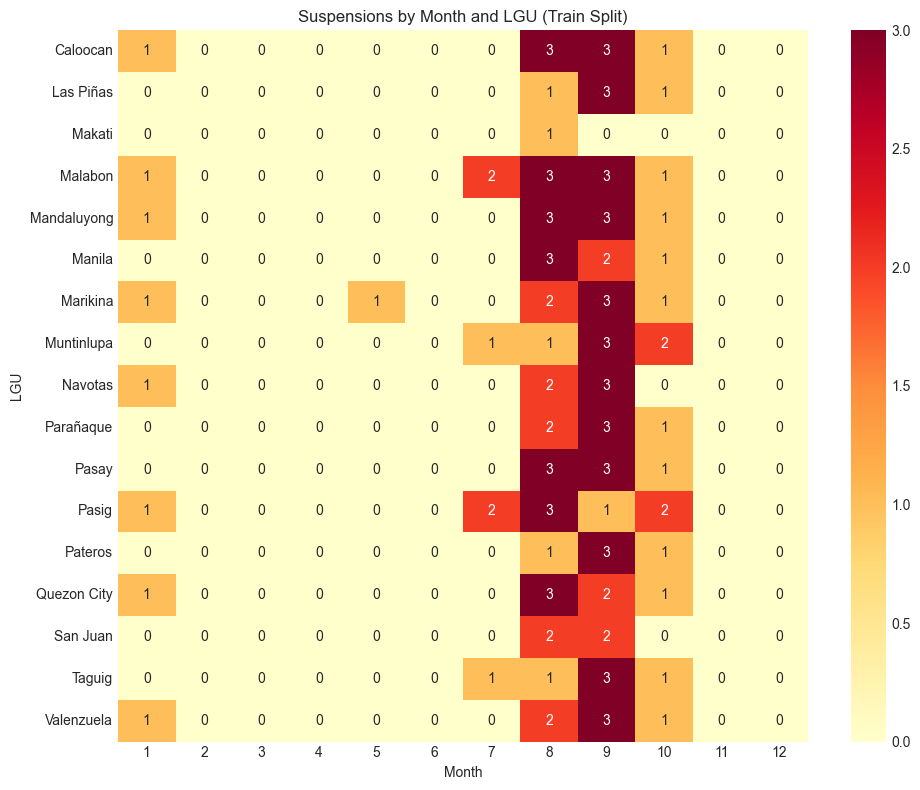

✅ Temporal pattern analysis complete


In [41]:
# Cell 1.2: Temporal Patterns
# Time series of daily suspension rate
train_daily = train.groupby('date')['suspension_occurred'].mean().reset_index()
val_daily = val.groupby('date')['suspension_occurred'].mean().reset_index()

# Smooth with 7-day moving average
train_daily['susp_rate_smooth'] = train_daily['suspension_occurred'].rolling(window=7, min_periods=1).mean()
val_daily['susp_rate_smooth'] = val_daily['suspension_occurred'].rolling(window=7, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_daily['date'], train_daily['susp_rate_smooth'], label='Train', alpha=0.7, linewidth=2)
ax.plot(val_daily['date'], val_daily['susp_rate_smooth'], label='Validation', alpha=0.7, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Suspension Rate (7-day moving avg)')
ax.set_title('Daily Suspension Rate Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

# Heatmap: suspensions by month and LGU (train only)
train_heatmap = train.groupby(['month', 'lgu_name'])['suspension_occurred'].sum().reset_index()
train_heatmap_pivot = train_heatmap.pivot(index='lgu_name', columns='month', values='suspension_occurred').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(train_heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax)
ax.set_title('Suspensions by Month and LGU (Train Split)')
ax.set_xlabel('Month')
ax.set_ylabel('LGU')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'suspensions_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Temporal pattern analysis complete")


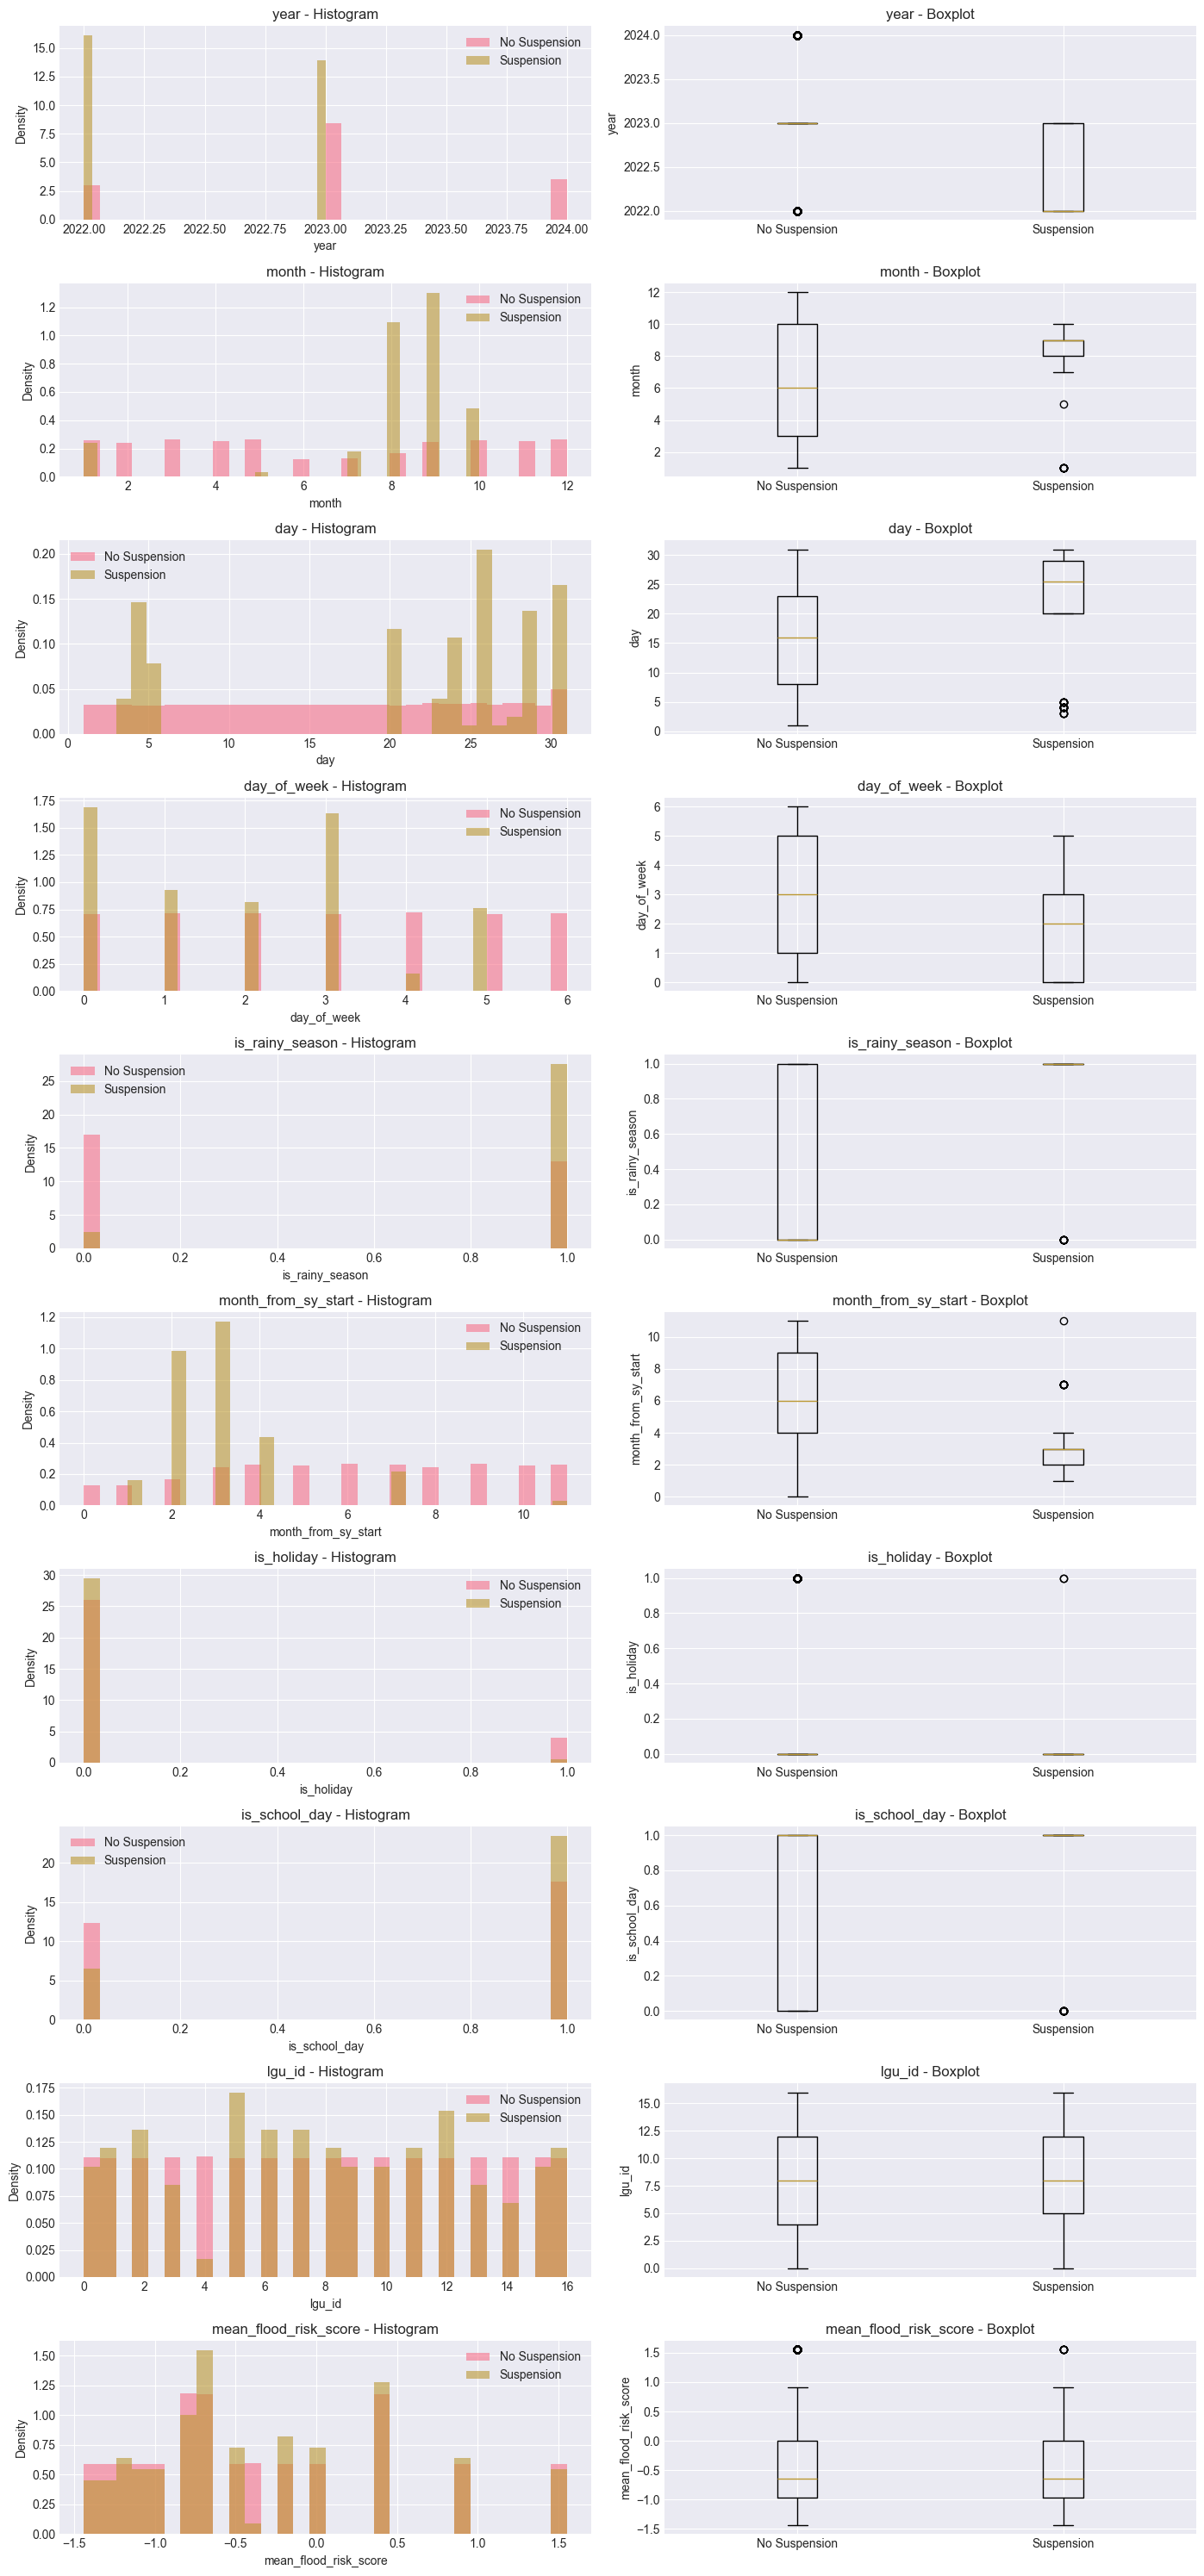

✅ Feature distribution analysis complete


In [42]:
# Cell 1.3: Feature Distributions by Class
# Select top numeric features
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['suspension_occurred', 'date']][:10]

fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 3*len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    # Histogram
    train_0 = train[train['suspension_occurred'] == 0][col].dropna()
    train_1 = train[train['suspension_occurred'] == 1][col].dropna()
    axes[i, 0].hist(train_0, bins=30, alpha=0.6, label='No Suspension', density=True)
    axes[i, 0].hist(train_1, bins=30, alpha=0.6, label='Suspension', density=True)
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].legend()
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Density')
    
    # Boxplot
    data_for_box = [train_0.values, train_1.values]
    axes[i, 1].boxplot(data_for_box, labels=['No Suspension', 'Suspension'])
    axes[i, 1].set_title(f'{col} - Boxplot')
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Feature distribution analysis complete")


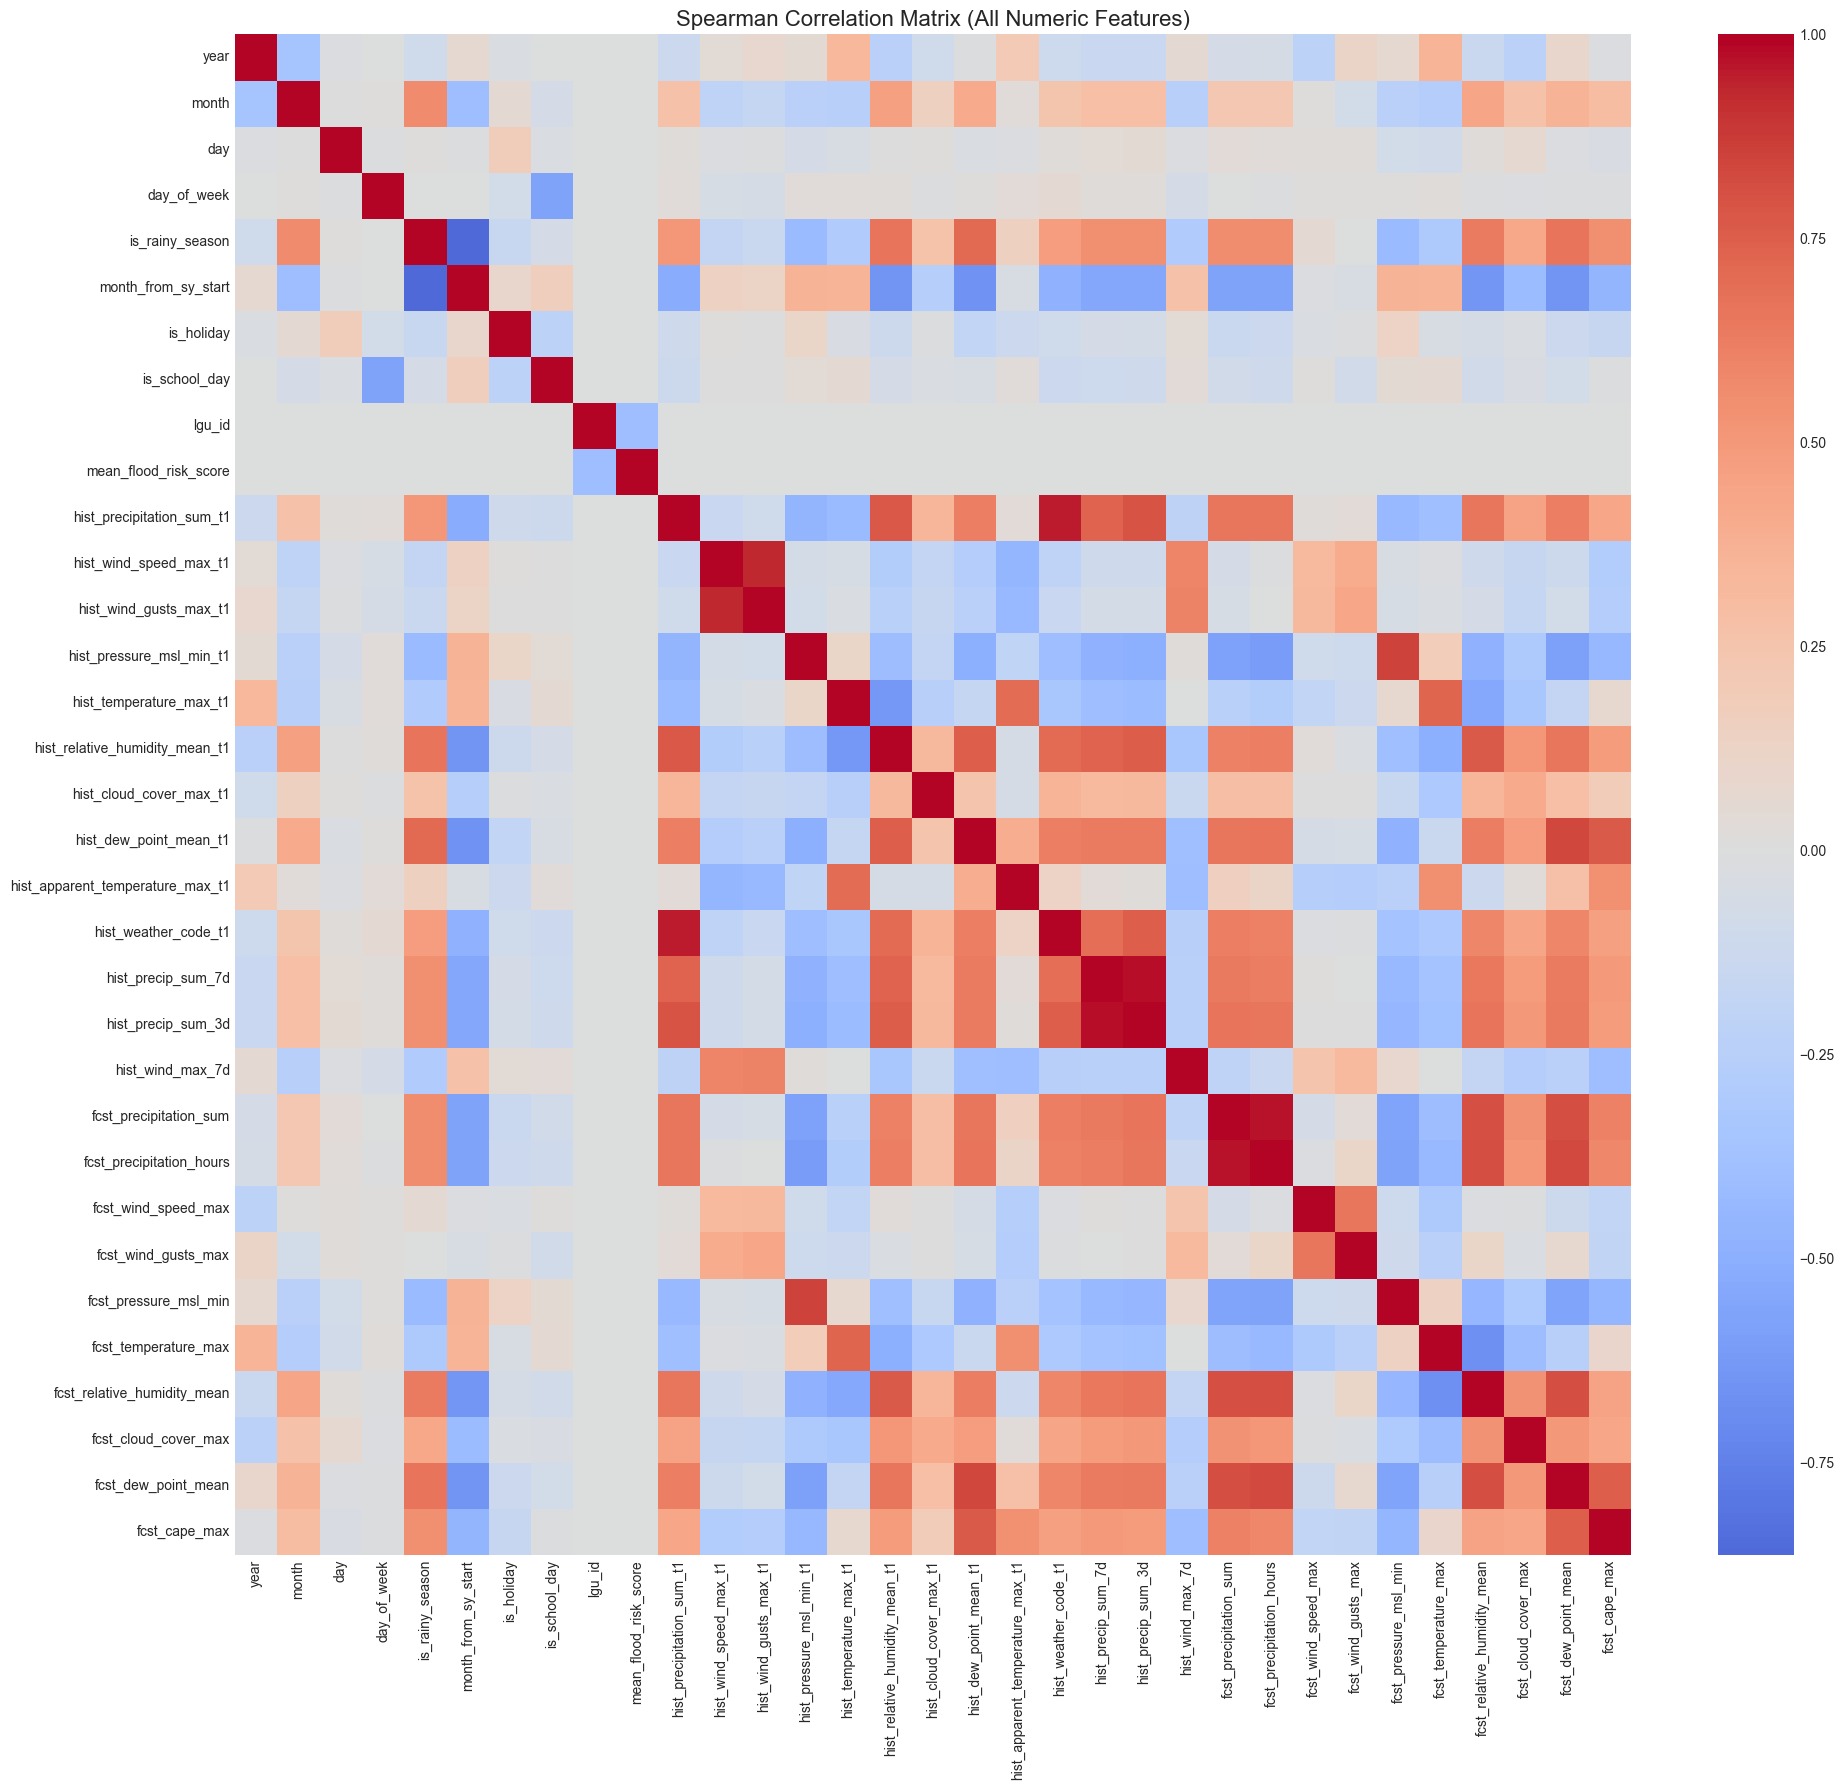


Found 12 highly correlated pairs (|corr| > 0.8):
  is_rainy_season <-> month_from_sy_start: -0.863
  hist_precipitation_sum_t1 <-> hist_weather_code_t1: 0.952
  hist_wind_speed_max_t1 <-> hist_wind_gusts_max_t1: 0.931
  hist_pressure_msl_min_t1 <-> fcst_pressure_msl_min: 0.854
  hist_dew_point_mean_t1 <-> fcst_dew_point_mean: 0.834
  hist_precip_sum_7d <-> hist_precip_sum_3d: 0.976
  fcst_precipitation_sum <-> fcst_precipitation_hours: 0.964
  fcst_precipitation_sum <-> fcst_relative_humidity_mean: 0.807
  fcst_precipitation_sum <-> fcst_dew_point_mean: 0.813
  fcst_precipitation_hours <-> fcst_relative_humidity_mean: 0.814

✅ Correlation analysis complete


In [43]:
# Cell 1.4: Correlation Matrix & Redundancy Check
from scipy.stats import spearmanr

# Combine train and val for correlation analysis
all_data = pd.concat([train, val], ignore_index=True)
numeric_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c not in ['suspension_occurred', 'date']]

# Compute Spearman correlation
corr_matrix = all_data[numeric_features].corr(method='spearman')

# Plot heatmap
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title('Spearman Correlation Matrix (All Numeric Features)', fontsize=16)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (|corr| > 0.8):")
for feat1, feat2, corr in high_corr_pairs[:10]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

print("\n✅ Correlation analysis complete")


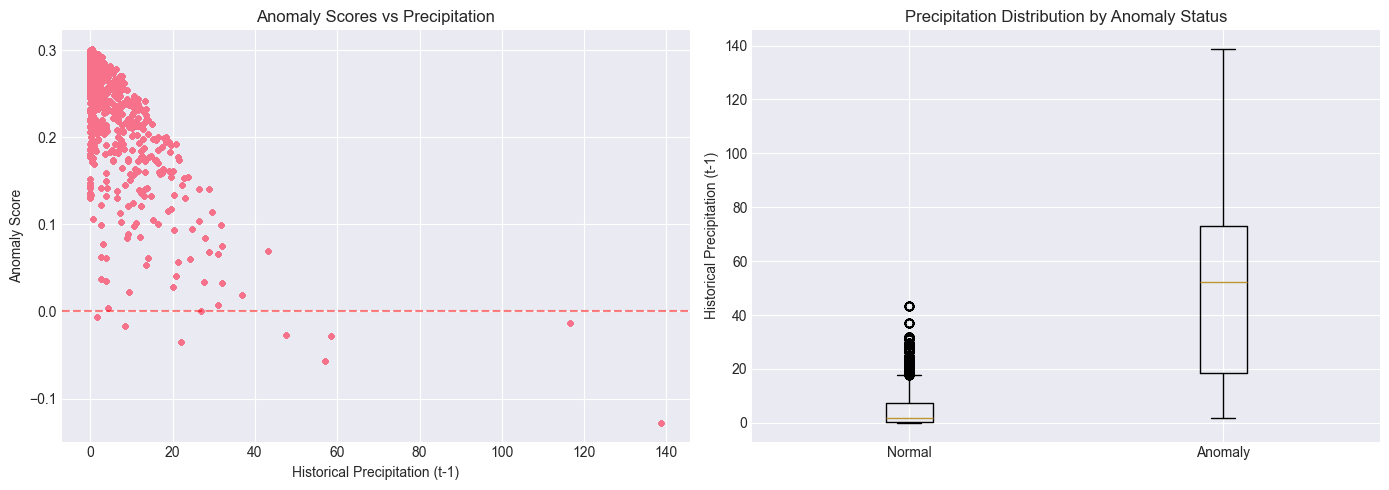


Top 10 anomalies (unusual weather but no suspension called):
          date     lgu_name  hist_precipitation_sum_t1  \
578 2022-09-25       Manila                        1.7   
579 2022-09-25  Quezon City                        1.7   
580 2022-09-25     Caloocan                        1.7   
581 2022-09-25    Las Piñas                        1.7   
582 2022-09-25       Makati                        1.7   
583 2022-09-25      Malabon                        1.7   
584 2022-09-25  Mandaluyong                        1.7   
585 2022-09-25     Marikina                        1.7   
586 2022-09-25   Muntinlupa                        1.7   
587 2022-09-25      Navotas                        1.7   

     hist_wind_gusts_max_t1  hist_pressure_msl_min_t1  fcst_precipitation_sum  
578                    21.6                    1003.7                    71.5  
579                    21.6                    1003.7                    71.5  
580                    21.6                    1003.7      

In [44]:
# Cell 1.5: Anomaly Detection (Isolation Forest) for Outlier Inspection
# Select features for anomaly detection
anomaly_features = ['hist_precipitation_sum_t1', 'hist_wind_gusts_max_t1', 
                    'hist_pressure_msl_min_t1', 'fcst_precipitation_sum']

# Fit Isolation Forest on training set (non-suspension days only)
train_no_susp = train[train['suspension_occurred'] == 0][anomaly_features].dropna()

iso_forest = IsolationForest(contamination=0.01, random_state=RANDOM_SEED, n_jobs=-1)
iso_forest.fit(train_no_susp)

# Get anomaly scores
train_anomaly_scores = iso_forest.decision_function(train[anomaly_features].fillna(0))
train_anomaly_labels = iso_forest.predict(train[anomaly_features].fillna(0))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(train['hist_precipitation_sum_t1'], train_anomaly_scores, alpha=0.5, s=10)
axes[0].set_xlabel('Historical Precipitation (t-1)')
axes[0].set_ylabel('Anomaly Score')
axes[0].set_title('Anomaly Scores vs Precipitation')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

train_boxplot_data = [
    train[train_anomaly_labels == 1]['hist_precipitation_sum_t1'].values,
    train[train_anomaly_labels == -1]['hist_precipitation_sum_t1'].values
]
axes[1].boxplot(train_boxplot_data, labels=['Normal', 'Anomaly'])
axes[1].set_ylabel('Historical Precipitation (t-1)')
axes[1].set_title('Precipitation Distribution by Anomaly Status')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'anomaly_detection.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top 10 anomalies
anomaly_indices = train[train_anomaly_labels == -1].copy()
print(f"\nTop 10 anomalies (unusual weather but no suspension called):")
print(anomaly_indices[['date', 'lgu_name'] + anomaly_features].head(10))

print("\n✅ Anomaly detection complete")


## Section 2: Feature Selection & Preparation


In [45]:
# Cell 2.1: Define DO_NOT_DROP List
# Features that must NEVER be removed

DO_NOT_DROP = [
    'lgu_id',              # Required for LGU embedding
    'mean_flood_risk_score', # Policy critical
    'is_school_day',       # Policy critical
    'is_holiday',          # Policy critical
    'school_year',         # Audit required
    'month',               # Audit required
    'month_from_sy_start', # Audit required
    'year',                # Audit required
    'day_of_week'          # Audit required
]

print("DO_NOT_DROP features defined:")
for feat in DO_NOT_DROP:
    print(f"  - {feat}: Policy/interpretability/embedding critical")

print(f"\nTotal protected features: {len(DO_NOT_DROP)}")


DO_NOT_DROP features defined:
  - lgu_id: Policy/interpretability/embedding critical
  - mean_flood_risk_score: Policy/interpretability/embedding critical
  - is_school_day: Policy/interpretability/embedding critical
  - is_holiday: Policy/interpretability/embedding critical
  - school_year: Policy/interpretability/embedding critical
  - month: Policy/interpretability/embedding critical
  - month_from_sy_start: Policy/interpretability/embedding critical
  - year: Policy/interpretability/embedding critical
  - day_of_week: Policy/interpretability/embedding critical

Total protected features: 9


In [46]:
# Cell 2.2: Stage 1 - Univariate Feature Selection
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

# Get initial features
all_features = train.select_dtypes(include=[np.number]).columns.tolist()
all_features = [c for c in all_features if c not in ['suspension_occurred', 'date']]

print(f"Initial feature count: {len(all_features)}")

# Split into numeric and categorical
numeric_features = [f for f in all_features if train[f].dtype in [np.float64, np.int64]]
print(f"Numeric features: {len(numeric_features)}")

# Compute F-statistic and p-values for numeric features
X_train_numeric = train[numeric_features].fillna(train[numeric_features].median())
y_train_vals = train['suspension_occurred'].values

f_scores, p_values = f_classif(X_train_numeric, y_train_vals)

# Create results DataFrame
feat_results = pd.DataFrame({
    'feature': numeric_features,
    'f_score': f_scores,
    'p_value': p_values
})

# Determine action
feat_results['action'] = feat_results.apply(
    lambda row: 'KEEP (protected)' if row['feature'] in DO_NOT_DROP 
    else 'DROP' if row['p_value'] > 0.05 
    else 'KEEP', 
    axis=1
)

# Print summary
print(f"\nStage 1 Feature Selection Summary:")
print(f"  Features with p > 0.05: {(feat_results['p_value'] > 0.05).sum()}")
print(f"  Features to drop: {(feat_results['action'] == 'DROP').sum()}")
print(f"  Protected features kept: {(feat_results['action'] == 'KEEP (protected)').sum()}")

# Show features to drop
features_to_drop_stage1 = feat_results[feat_results['action'] == 'DROP']['feature'].tolist()
print(f"\nFeatures to drop ({len(features_to_drop_stage1)}):")
for feat in features_to_drop_stage1[:10]:
    print(f"  - {feat}")

print("\n✅ Stage 1 (Univariate) complete")


Initial feature count: 33
Numeric features: 33

Stage 1 Feature Selection Summary:
  Features with p > 0.05: 3
  Features to drop: 1
  Protected features kept: 8

Features to drop (1):
  - fcst_cape_max

✅ Stage 1 (Univariate) complete


In [47]:
# Cell 2.3: Stage 2 - Redundancy Removal (Correlation Filtering)
# Apply Stage 1 filtering first
features_after_stage1 = feat_results[feat_results['action'] != 'DROP']['feature'].tolist()

# Get correlation matrix for remaining features
corr_matrix_stage2 = train[features_after_stage1].corr(method='spearman')

# Find highly correlated pairs
high_corr_to_check = []
for i in range(len(corr_matrix_stage2.columns)):
    for j in range(i+1, len(corr_matrix_stage2.columns)):
        corr_val = corr_matrix_stage2.iloc[i, j]
        if abs(corr_val) > 0.8:
            feat1 = corr_matrix_stage2.columns[i]
            feat2 = corr_matrix_stage2.columns[j]
            high_corr_to_check.append((feat1, feat2, corr_val))

# Check which pairs to actually drop
features_to_drop_stage2 = []
lag_keywords = ['sum_3d', 'sum_7d', 't1', 'max_7d']

print(f"\nStage 2: Redundancy Removal")
print(f"  Highly correlated pairs (|corr| > 0.8): {len(high_corr_to_check)}")

for feat1, feat2, corr_val in high_corr_to_check:
    # Skip if either is in DO_NOT_DROP
    if feat1 in DO_NOT_DROP or feat2 in DO_NOT_DROP:
        print(f"  KEEP: {feat1} <-> {feat2} (one is protected)")
        continue
    
    # Skip if either is a lag feature
    is_lag_feat1 = any(keyword in feat1 for keyword in lag_keywords)
    is_lag_feat2 = any(keyword in feat2 for keyword in lag_keywords)
    if is_lag_feat1 or is_lag_feat2:
        print(f"  KEEP: {feat1} <-> {feat2} (one is lag feature)")
        continue
    
    # Drop feature with lower correlation to target
    corr1_to_target = train[feat1].corr(train['suspension_occurred'])
    corr2_to_target = train[feat2].corr(train['suspension_occurred'])
    
    if abs(corr1_to_target) < abs(corr2_to_target):
        features_to_drop_stage2.append(feat1)
        print(f"  DROP: {feat1} (lower target corr: {corr1_to_target:.3f} vs {corr2_to_target:.3f})")
    else:
        features_to_drop_stage2.append(feat2)
        print(f"  DROP: {feat2} (lower target corr: {corr2_to_target:.3f} vs {corr1_to_target:.3f})")

print(f"\nFeatures to drop in Stage 2: {len(features_to_drop_stage2)}")
print("✅ Stage 2 (Redundancy Removal) complete")



Stage 2: Redundancy Removal
  Highly correlated pairs (|corr| > 0.8): 10
  KEEP: is_rainy_season <-> month_from_sy_start (one is protected)
  KEEP: hist_precipitation_sum_t1 <-> hist_weather_code_t1 (one is lag feature)
  KEEP: hist_wind_speed_max_t1 <-> hist_wind_gusts_max_t1 (one is lag feature)
  KEEP: hist_pressure_msl_min_t1 <-> fcst_pressure_msl_min (one is lag feature)
  KEEP: hist_dew_point_mean_t1 <-> fcst_dew_point_mean (one is lag feature)
  KEEP: hist_precip_sum_7d <-> hist_precip_sum_3d (one is lag feature)
  DROP: fcst_precipitation_hours (lower target corr: 0.158 vs 0.296)
  DROP: fcst_dew_point_mean (lower target corr: 0.075 vs 0.296)
  DROP: fcst_dew_point_mean (lower target corr: 0.075 vs 0.158)
  DROP: fcst_dew_point_mean (lower target corr: 0.075 vs 0.149)

Features to drop in Stage 2: 4
✅ Stage 2 (Redundancy Removal) complete


In [48]:
# Cell 2.4: Stage 3 - Prepare X/y for Training
# Get final feature list
all_features_to_drop = list(set(features_to_drop_stage1 + features_to_drop_stage2))
final_features = [f for f in all_features if f not in all_features_to_drop]

print(f"\nStage 3: Prepare X/y for Training")
print(f"Final feature count: {len(final_features)}")

# Prepare X and y
X_train = train[final_features].copy()
y_train = train['suspension_occurred'].copy()

X_val = val[final_features].copy()
y_val = val['suspension_occurred'].copy()

# Fill missing values with median (from train)
for col in X_train.columns:
    if X_train[col].isna().any():
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_val[col] = X_val[col].fillna(median_val)

# Verify no NaN
print(f"\nValidation checks:")
print(f"  X_train NaN count: {X_train.isna().sum().sum()}")
print(f"  X_val NaN count: {X_val.isna().sum().sum()}")
print(f"  Duplicates: {X_train.duplicated().sum()}")

# Print final feature list
print(f"\nFinal feature list ({len(final_features)} features):")
for i, feat in enumerate(final_features, 1):
    print(f"  {i:2d}. {feat}")

print("\n✅ Stage 3 complete - Data ready for training")



Stage 3: Prepare X/y for Training
Final feature count: 30

Validation checks:
  X_train NaN count: 0
  X_val NaN count: 0
  Duplicates: 0

Final feature list (30 features):
   1. year
   2. month
   3. day
   4. day_of_week
   5. is_rainy_season
   6. month_from_sy_start
   7. is_holiday
   8. is_school_day
   9. lgu_id
  10. mean_flood_risk_score
  11. hist_precipitation_sum_t1
  12. hist_wind_speed_max_t1
  13. hist_wind_gusts_max_t1
  14. hist_pressure_msl_min_t1
  15. hist_temperature_max_t1
  16. hist_relative_humidity_mean_t1
  17. hist_cloud_cover_max_t1
  18. hist_dew_point_mean_t1
  19. hist_apparent_temperature_max_t1
  20. hist_weather_code_t1
  21. hist_precip_sum_7d
  22. hist_precip_sum_3d
  23. hist_wind_max_7d
  24. fcst_precipitation_sum
  25. fcst_wind_speed_max
  26. fcst_wind_gusts_max
  27. fcst_pressure_msl_min
  28. fcst_temperature_max
  29. fcst_relative_humidity_mean
  30. fcst_cloud_cover_max

✅ Stage 3 complete - Data ready for training


## Section 3: Baseline Models (With Imbalance Handling)


Baseline (Dummy): F2=0.0000, Recall=0.0000, Precision=0.0000


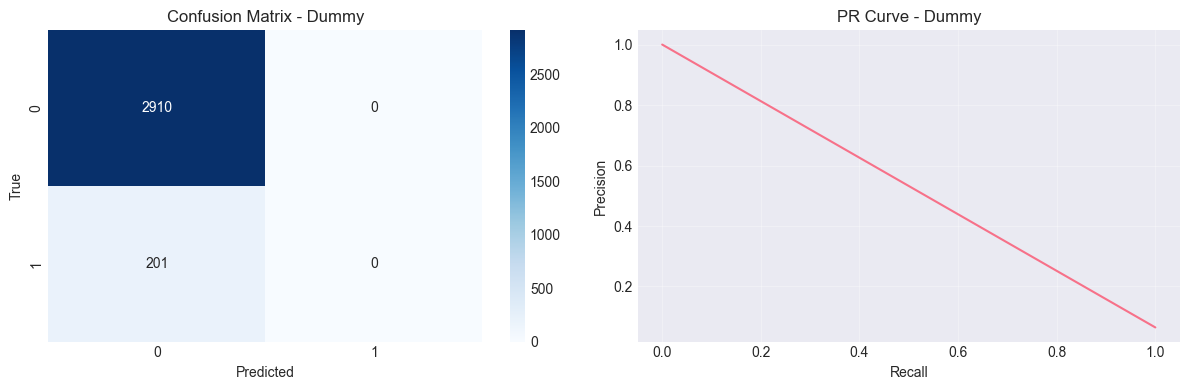

✅ Dummy classifier complete


In [49]:
# Cell 3.1: Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_val)
y_proba_dummy = dummy.predict_proba(X_val)[:, 1]

metrics_dummy = compute_all_metrics(y_val, y_pred_dummy, y_proba_dummy)
metrics_dummy['Model'] = 'Dummy Classifier'
metrics_dummy['SMOTE'] = False
metrics_dummy['Calibrated'] = False
metrics_dummy['Threshold'] = 0.5
results_list.append(metrics_dummy)

print(f"Baseline (Dummy): F2={metrics_dummy['F2']:.4f}, Recall={metrics_dummy['Recall']:.4f}, Precision={metrics_dummy['Precision']:.4f}")

# Confusion matrix
cm_dummy = confusion_matrix(y_val, y_pred_dummy)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Dummy')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# PR curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_proba_dummy)
axes[1].plot(recall_curve, precision_curve)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PR Curve - Dummy')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'baseline_dummy.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Dummy classifier complete")


In [50]:
# Cell 3.2: Logistic Regression (Default + Balanced)
# Default LR
lr_default = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_default.fit(X_train, y_train)

y_pred_lr_def = lr_default.predict(X_val)
y_proba_lr_def = lr_default.predict_proba(X_val)[:, 1]

metrics_lr_def = compute_all_metrics(y_val, y_pred_lr_def, y_proba_lr_def)
metrics_lr_def['Model'] = 'Logistic Regression'
metrics_lr_def['SMOTE'] = False
metrics_lr_def['Calibrated'] = False
metrics_lr_def['Threshold'] = 0.5
results_list.append(metrics_lr_def)

print(f"Logistic Regression (Default): F2={metrics_lr_def['F2']:.4f}, Recall={metrics_lr_def['Recall']:.4f}")

# Balanced LR
lr_balanced = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED, max_iter=1000)
lr_balanced.fit(X_train, y_train)

y_pred_lr_bal = lr_balanced.predict(X_val)
y_proba_lr_bal = lr_balanced.predict_proba(X_val)[:, 1]

metrics_lr_bal = compute_all_metrics(y_val, y_pred_lr_bal, y_proba_lr_bal)
metrics_lr_bal['Model'] = 'Logistic Regression Balanced'
metrics_lr_bal['SMOTE'] = False
metrics_lr_bal['Calibrated'] = False
metrics_lr_bal['Threshold'] = 0.5
results_list.append(metrics_lr_bal)

print(f"Logistic Regression (Balanced): F2={metrics_lr_bal['F2']:.4f}, Recall={metrics_lr_bal['Recall']:.4f}")

print("✅ Logistic Regression complete")


Logistic Regression (Default): F2=0.0365, Recall=0.0299
Logistic Regression (Balanced): F2=0.5473, Recall=0.5871
✅ Logistic Regression complete


## Section 4: Tree-Based Ensembles

Tree-based models with various imbalance handling strategies


In [51]:
# Cell 4.1-4.6: Tree-Based Models (RF, XGBoost, LightGBM with variants)
# Random Forest variants
rf_def = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_def.fit(X_train, y_train)
metrics_rf_def = compute_all_metrics(y_val, rf_def.predict(X_val), rf_def.predict_proba(X_val)[:, 1])
metrics_rf_def.update({'Model': 'Random Forest', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_rf_def)

rf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_SEED)
rf_bal.fit(X_train, y_train)
metrics_rf_bal = compute_all_metrics(y_val, rf_bal.predict(X_val), rf_bal.predict_proba(X_val)[:, 1])
metrics_rf_bal.update({'Model': 'Random Forest Balanced', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_rf_bal)

# Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
brf.fit(X_train, y_train)
metrics_brf = compute_all_metrics(y_val, brf.predict(X_val), brf.predict_proba(X_val)[:, 1])
metrics_brf.update({'Model': 'Balanced Random Forest', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_brf)

# RF + SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE resampling: {Counter(y_train)} -> {Counter(y_train_smote)}")

rf_smote = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_smote.fit(X_train_smote, y_train_smote)
metrics_rf_smote = compute_all_metrics(y_val, rf_smote.predict(X_val), rf_smote.predict_proba(X_val)[:, 1])
metrics_rf_smote.update({'Model': 'Random Forest + SMOTE', 'SMOTE': True, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_rf_smote)

# XGBoost variants
n_neg, n_pos = len(y_train[y_train==0]), len(y_train[y_train==1])

xgb_def = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric='logloss')
xgb_def.fit(X_train, y_train)
metrics_xgb_def = compute_all_metrics(y_val, xgb_def.predict(X_val), xgb_def.predict_proba(X_val)[:, 1])
metrics_xgb_def.update({'Model': 'XGBoost', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_xgb_def)

xgb_weight = XGBClassifier(n_estimators=100, scale_pos_weight=n_neg/n_pos, random_state=RANDOM_SEED, eval_metric='logloss')
xgb_weight.fit(X_train, y_train)
metrics_xgb_weight = compute_all_metrics(y_val, xgb_weight.predict(X_val), xgb_weight.predict_proba(X_val)[:, 1])
metrics_xgb_weight.update({'Model': 'XGBoost Weighted', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_xgb_weight)

# XGBoost + SMOTE
xgb_smote = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric='logloss')
xgb_smote.fit(X_train_smote, y_train_smote)
metrics_xgb_smote = compute_all_metrics(y_val, xgb_smote.predict(X_val), xgb_smote.predict_proba(X_val)[:, 1])
metrics_xgb_smote.update({'Model': 'XGBoost + SMOTE', 'SMOTE': True, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_xgb_smote)

# LightGBM variants
lgb_def = LGBMClassifier(n_estimators=100, random_state=RANDOM_SEED, verbose=-1)
lgb_def.fit(X_train, y_train)
metrics_lgb_def = compute_all_metrics(y_val, lgb_def.predict(X_val), lgb_def.predict_proba(X_val)[:, 1])
metrics_lgb_def.update({'Model': 'LightGBM', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_lgb_def)

lgb_unbalance = LGBMClassifier(n_estimators=100, is_unbalance=True, random_state=RANDOM_SEED, verbose=-1)
lgb_unbalance.fit(X_train, y_train)
metrics_lgb_unbal = compute_all_metrics(y_val, lgb_unbalance.predict(X_val), lgb_unbalance.predict_proba(X_val)[:, 1])
metrics_lgb_unbal.update({'Model': 'LightGBM Unbalanced', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_lgb_unbal)

# LightGBM + SMOTE
lgb_smote = LGBMClassifier(n_estimators=100, random_state=RANDOM_SEED, verbose=-1)
lgb_smote.fit(X_train_smote, y_train_smote)
metrics_lgb_smote = compute_all_metrics(y_val, lgb_smote.predict(X_val), lgb_smote.predict_proba(X_val)[:, 1])
metrics_lgb_smote.update({'Model': 'LightGBM + SMOTE', 'SMOTE': True, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_lgb_smote)

print(f"✅ Tree-based models complete: {sum(1 for r in results_list if r['Model'] in ['Random Forest', 'XGBoost', 'LightGBM', 'Balanced Random Forest'])} models trained")

SMOTE resampling: Counter({0: 10923, 1: 110}) -> Counter({0: 10923, 1: 10923})
✅ Tree-based models complete: 4 models trained


## Section 5: Advanced Ensembles (EasyEnsemble, Gradient Boosting)


In [52]:
# Cell 5.1: EasyEnsemble Classifier
easy_ensemble = EasyEnsembleClassifier(n_estimators=50, random_state=RANDOM_SEED, n_jobs=-1)
easy_ensemble.fit(X_train, y_train)

y_pred_ee = easy_ensemble.predict(X_val)
y_proba_ee = easy_ensemble.predict_proba(X_val)[:, 1]

metrics_ee = compute_all_metrics(y_val, y_pred_ee, y_proba_ee)
metrics_ee.update({'Model': 'EasyEnsemble', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_ee)

print(f"EasyEnsemble: F2={metrics_ee['F2']:.4f}, Recall={metrics_ee['Recall']:.4f}, Precision={metrics_ee['Precision']:.4f}")
print("✅ EasyEnsemble complete")


EasyEnsemble: F2=0.5458, Recall=0.5871, Precision=0.4260
✅ EasyEnsemble complete


In [53]:
# Cell 5.2: Gradient Boosting (Conservative Settings)
gb_conservative = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=4,
    min_samples_split=50,
    min_samples_leaf=10,
    random_state=RANDOM_SEED
)
gb_conservative.fit(X_train, y_train)

y_pred_gb = gb_conservative.predict(X_val)
y_proba_gb = gb_conservative.predict_proba(X_val)[:, 1]

metrics_gb = compute_all_metrics(y_val, y_pred_gb, y_proba_gb)
metrics_gb.update({'Model': 'Gradient Boosting Conservative', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
results_list.append(metrics_gb)

print(f"Gradient Boosting (Conservative): F2={metrics_gb['F2']:.4f}, Recall={metrics_gb['Recall']:.4f}, Precision={metrics_gb['Precision']:.4f}")
print("✅ Gradient Boosting complete")


Gradient Boosting (Conservative): F2=0.0000, Recall=0.0000, Precision=0.0000
✅ Gradient Boosting complete


## Section 6: Neural Networks (Keras/TensorFlow)


In [54]:
# Cell 6.1: Neural Network Setup (Only if TensorFlow available)
if TENSORFLOW_AVAILABLE:
    # Scale features
    scaler_nn = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler_nn.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val_scaled = pd.DataFrame(
        scaler_nn.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )
    
    # Separate lgu_id for embedding
    X_train_lgu = X_train['lgu_id'].values
    X_train_features = X_train_scaled.drop('lgu_id', axis=1)
    
    X_val_lgu = X_val['lgu_id'].values
    X_val_features = X_val_scaled.drop('lgu_id', axis=1)
    
    print("✅ Neural network data prepared")
    print(f"  LGU IDs separated for embedding: 17 categories")
    print(f"  Features scaled and ready")
else:
    print("⚠️  TensorFlow not available, skipping neural network section")


✅ Neural network data prepared
  LGU IDs separated for embedding: 17 categories
  Features scaled and ready


In [55]:
# Cell 6.2: MLP with LGU Embedding + Class Weights
if TENSORFLOW_AVAILABLE:
    # Input layers
    input_lgu = layers.Input(shape=(1,), name='input_lgu')
    input_features = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    # LGU Embedding
    lgu_embedding = layers.Embedding(input_dim=17, output_dim=4, name='lgu_embedding')(input_lgu)
    lgu_flat = layers.Flatten()(lgu_embedding)
    
    # Concatenate
    concat = layers.Concatenate()([lgu_flat, input_features])
    
    # Dense layers
    dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01))(concat)
    bn1 = layers.BatchNormalization()(dense1)
    dropout1 = layers.Dropout(0.4)(bn1)
    
    dense2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.01))(dropout1)
    bn2 = layers.BatchNormalization()(dense2)
    dropout2 = layers.Dropout(0.3)(bn2)
    
    dense3 = layers.Dense(16, activation='relu')(dropout2)
    dropout3 = layers.Dropout(0.2)(dense3)
    
    output = layers.Dense(1, activation='sigmoid', name='output')(dropout3)
    
    # Build model
    model_nn = keras.Model(inputs=[input_lgu, input_features], outputs=output)
    
    # Compile
    model_nn.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.BinaryCrossentropy(),
        metrics=[metrics.Precision(), metrics.Recall()]
    )
    
    # Class weights
    class_weight = {0: 1.0, 1: (n_neg / n_pos) * 0.5}
    
    # Train with EarlyStopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    print("Training neural network...")
    history = model_nn.fit(
        [X_train_lgu, X_train_features],
        y_train,
        validation_data=([X_val_lgu, X_val_features], y_val),
        epochs=100,
        batch_size=128,
        class_weight=class_weight,
        callbacks=[early_stop],
        verbose=0
    )
    
    print("✅ Neural network training complete")
else:
    model_nn = None


Training neural network...
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 14.
✅ Neural network training complete


In [56]:
# Cell 6.3: Predict & Evaluate Neural Network
if TENSORFLOW_AVAILABLE and model_nn is not None:
    y_proba_nn = model_nn.predict([X_val_lgu, X_val_features], verbose=0)
    y_proba_nn = y_proba_nn.flatten()
    y_pred_nn = (y_proba_nn >= 0.5).astype(int)
    
    metrics_nn = compute_all_metrics(y_val, y_pred_nn, y_proba_nn)
    metrics_nn.update({'Model': 'Neural Network', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_nn)
    
    print(f"Neural Network: F2={metrics_nn['F2']:.4f}, Recall={metrics_nn['Recall']:.4f}, Precision={metrics_nn['Precision']:.4f}")
    print("✅ Neural network evaluation complete")
else:
    print("⚠️  Skipping neural network evaluation (TensorFlow not available)")


Neural Network: F2=0.3818, Recall=0.3632, Precision=0.4803
✅ Neural network evaluation complete


In [58]:
# Cell 6.4: Additional Neural Network Variants
if TENSORFLOW_AVAILABLE:
    from tensorflow import keras
    from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, regularizers
    import tensorflow as tf
    
    # Focal Loss function for handling class imbalance
    def focal_loss(gamma=2.0, alpha=0.25):
        def loss(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
            p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
            alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
            focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
            ce_loss = -tf.math.log(p_t)
            return tf.reduce_mean(focal_weight * ce_loss)
        return loss
    
    # Variant 1: Neural Network with Focal Loss (Small Architecture)
    print("Training Neural Network with Focal Loss (Small)...")
    input_lgu_focal_small = layers.Input(shape=(1,), name='input_lgu')
    input_features_focal_small = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    lgu_emb_focal_small = layers.Embedding(input_dim=17, output_dim=4, name='lgu_embedding')(input_lgu_focal_small)
    lgu_flat_focal_small = layers.Flatten()(lgu_emb_focal_small)
    
    concat_focal_small = layers.Concatenate()([lgu_flat_focal_small, input_features_focal_small])
    x_focal_small = layers.Dense(64, activation='relu')(concat_focal_small)
    x_focal_small = layers.BatchNormalization()(x_focal_small)
    x_focal_small = layers.Dropout(0.3)(x_focal_small)
    x_focal_small = layers.Dense(32, activation='relu')(x_focal_small)
    x_focal_small = layers.Dropout(0.2)(x_focal_small)
    output_focal_small = layers.Dense(1, activation='sigmoid')(x_focal_small)
    
    model_focal_small = keras.Model(inputs=[input_lgu_focal_small, input_features_focal_small], outputs=output_focal_small)
    model_focal_small.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    
    early_stop_nn = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_focal_small.fit([X_train_lgu, X_train_features], y_train,
                         validation_data=([X_val_lgu, X_val_features], y_val),
                         epochs=50, batch_size=32, callbacks=[early_stop_nn], verbose=0)
    
    y_proba_focal_small = model_focal_small.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    y_pred_focal_small = (y_proba_focal_small >= 0.5).astype(int)
    metrics_focal_small = compute_all_metrics(y_val, y_pred_focal_small, y_proba_focal_small)
    metrics_focal_small.update({'Model': 'Neural Network (Small + Focal)', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_focal_small)
    print(f"  F2={metrics_focal_small['F2']:.4f}, Recall={metrics_focal_small['Recall']:.4f}")
    
    # Variant 2: Neural Network with Focal Loss (Deep Architecture)
    print("Training Neural Network with Focal Loss (Deep)...")
    input_lgu_focal_deep = layers.Input(shape=(1,), name='input_lgu')
    input_features_focal_deep = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    lgu_emb_focal_deep = layers.Embedding(input_dim=17, output_dim=8, name='lgu_embedding')(input_lgu_focal_deep)
    lgu_flat_focal_deep = layers.Flatten()(lgu_emb_focal_deep)
    
    concat_focal_deep = layers.Concatenate()([lgu_flat_focal_deep, input_features_focal_deep])
    x_focal_deep = layers.Dense(128, activation='relu')(concat_focal_deep)
    x_focal_deep = layers.BatchNormalization()(x_focal_deep)
    x_focal_deep = layers.Dropout(0.4)(x_focal_deep)
    x_focal_deep = layers.Dense(64, activation='relu')(x_focal_deep)
    x_focal_deep = layers.BatchNormalization()(x_focal_deep)
    x_focal_deep = layers.Dropout(0.3)(x_focal_deep)
    x_focal_deep = layers.Dense(32, activation='relu')(x_focal_deep)
    x_focal_deep = layers.Dropout(0.2)(x_focal_deep)
    output_focal_deep = layers.Dense(1, activation='sigmoid')(x_focal_deep)
    
    model_focal_deep = keras.Model(inputs=[input_lgu_focal_deep, input_features_focal_deep], outputs=output_focal_deep)
    model_focal_deep.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    
    model_focal_deep.fit([X_train_lgu, X_train_features], y_train,
                        validation_data=([X_val_lgu, X_val_features], y_val),
                        epochs=50, batch_size=32, callbacks=[early_stop_nn], verbose=0)
    
    y_proba_focal_deep = model_focal_deep.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    y_pred_focal_deep = (y_proba_focal_deep >= 0.5).astype(int)
    metrics_focal_deep = compute_all_metrics(y_val, y_pred_focal_deep, y_proba_focal_deep)
    metrics_focal_deep.update({'Model': 'Neural Network (Deep + Focal)', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_focal_deep)
    print(f"  F2={metrics_focal_deep['F2']:.4f}, Recall={metrics_focal_deep['Recall']:.4f}")
    
    # Variant 3: Neural Network with Class Weight + Strong Regularization
    print("Training Neural Network with Class Weight + Strong Regularization...")
    class_weight_nn = {0: 1.0, 1: (n_neg / n_pos) * 0.5}
    
    input_lgu_reg = layers.Input(shape=(1,), name='input_lgu')
    input_features_reg = layers.Input(shape=(X_train_features.shape[1],), name='input_features')
    
    lgu_emb_reg = layers.Embedding(input_dim=17, output_dim=8, name='lgu_embedding')(input_lgu_reg)
    lgu_flat_reg = layers.Flatten()(lgu_emb_reg)
    
    concat_reg = layers.Concatenate()([lgu_flat_reg, input_features_reg])
    x_reg = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.01))(concat_reg)
    x_reg = layers.BatchNormalization()(x_reg)
    x_reg = layers.Dropout(0.4)(x_reg)
    x_reg = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01))(x_reg)
    x_reg = layers.BatchNormalization()(x_reg)
    x_reg = layers.Dropout(0.3)(x_reg)
    x_reg = layers.Dense(32, activation='relu')(x_reg)
    x_reg = layers.Dropout(0.2)(x_reg)
    output_reg = layers.Dense(1, activation='sigmoid')(x_reg)
    
    model_reg = keras.Model(inputs=[input_lgu_reg, input_features_reg], outputs=output_reg)
    model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model_reg.fit([X_train_lgu, X_train_features], y_train,
                 validation_data=([X_val_lgu, X_val_features], y_val),
                 epochs=50, batch_size=32, class_weight=class_weight_nn, callbacks=[early_stop_nn], verbose=0)
    
    y_proba_reg = model_reg.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    y_pred_reg = (y_proba_reg >= 0.5).astype(int)
    metrics_reg = compute_all_metrics(y_val, y_pred_reg, y_proba_reg)
    metrics_reg.update({'Model': 'Neural Network (Deep + ClassWeight)', 'SMOTE': False, 'Calibrated': False, 'Threshold': 0.5})
    results_list.append(metrics_reg)
    print(f"  F2={metrics_reg['F2']:.4f}, Recall={metrics_reg['Recall']:.4f}")
    
    print("✅ All neural network variants complete")


Training Neural Network with Focal Loss (Small)...
  F2=0.0000, Recall=0.0000
Training Neural Network with Focal Loss (Deep)...
  F2=0.0000, Recall=0.0000
Training Neural Network with Class Weight + Strong Regularization...
  F2=0.4518, Recall=0.4527
✅ All neural network variants complete


## Section 7: Threshold Tuning for High Precision


Optimal threshold for 80% precision: 0.1900
Achieved Precision: 0.8108, Recall: 0.1493, F2: 0.1784


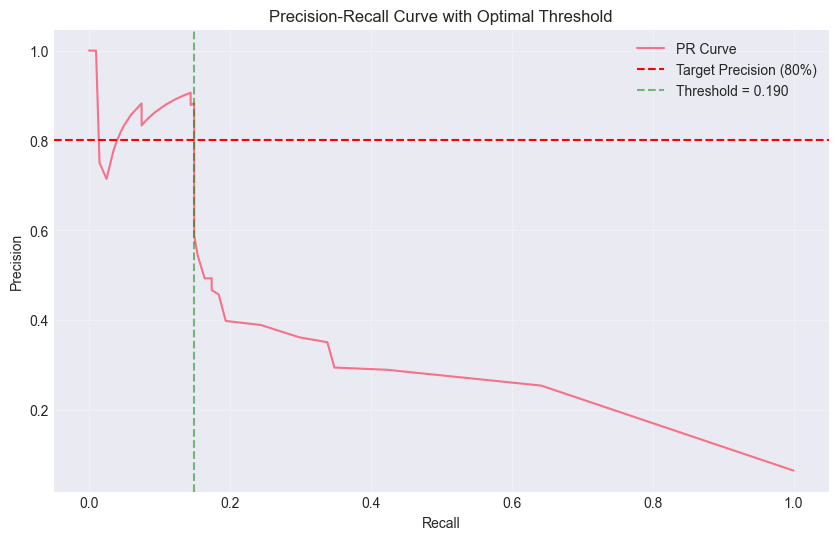

✅ Threshold tuning complete


In [ ]:
# Cell 7.1: Precision-Recall Curve & Optimal Threshold
def find_optimal_threshold_for_precision(y_true, y_proba, target_precision=0.80):
    """Find threshold where precision >= target_precision."""
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Find first threshold where precision >= target
    valid_idx = np.where(precision_curve >= target_precision)[0]
    if len(valid_idx) > 0:
        opt_idx = valid_idx[0]
        threshold = thresholds[opt_idx] if opt_idx < len(thresholds) else thresholds[-1]
        achieved_prec = precision_curve[opt_idx]
        achieved_rec = recall_curve[opt_idx]
    else:
        threshold = 0.5
        achieved_prec = precision_score(y_true, y_proba >= threshold)
        achieved_rec = recall_score(y_true, y_proba >= threshold)
    
    return threshold, achieved_prec, achieved_rec

# Get current best model (by F2 score from results)
# For threshold tuning, use a strong baseline model
best_model_for_threshold = rf_bal  # Using balanced RF as example

y_proba_best_val = best_model_for_threshold.predict_proba(X_val)[:, 1]
threshold_opt, prec_opt, rec_opt = find_optimal_threshold_for_precision(y_val, y_proba_best_val, 0.80)

y_pred_tuned = (y_proba_best_val >= threshold_opt).astype(int)
metrics_tuned = compute_all_metrics(y_val, y_pred_tuned, y_proba_best_val)
metrics_tuned.update({'Model': 'Best Model (Tuned Threshold)', 'SMOTE': False, 'Calibrated': False, 'Threshold': threshold_opt})
results_list.append(metrics_tuned)

print(f"Optimal threshold for 80% precision: {threshold_opt:.4f}")
print(f"Achieved Precision: {prec_opt:.4f}, Recall: {rec_opt:.4f}, F2: {metrics_tuned['F2']:.4f}")

# Plot PR curve with threshold marked
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_proba_best_val)
plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label='PR Curve')
plt.axhline(y=0.80, color='r', linestyle='--', label='Target Precision (80%)')
plt.axvline(x=rec_opt, color='g', linestyle='--', alpha=0.5, label=f'Threshold = {threshold_opt:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(PROCESSED_DIR / 'pr_curve_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Threshold tuning complete")


In [ ]:
# Cell 7.2: Calibration (Optional but Recommended)
# Calibrate best model
best_model_for_calibration = rf_bal  # Using balanced RF as example

calibrated_model = CalibratedClassifierCV(best_model_for_calibration, method='isotonic', cv='prefit')
calibrated_model.fit(X_val, y_val)

y_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]
threshold_cal, prec_cal, rec_cal = find_optimal_threshold_for_precision(y_val, y_proba_calibrated, 0.80)

y_pred_cal = (y_proba_calibrated >= threshold_cal).astype(int)
metrics_calibrated = compute_all_metrics(y_val, y_pred_cal, y_proba_calibrated)
metrics_calibrated.update({'Model': 'Best Model (Calibrated + Tuned)', 'SMOTE': False, 'Calibrated': True, 'Threshold': threshold_cal})
results_list.append(metrics_calibrated)

print(f"\nCalibration Comparison:")
print(f"  Before: Precision={prec_opt:.4f}, Recall={rec_opt:.4f}, F2={metrics_tuned['F2']:.4f}")
print(f"  After:  Precision={prec_cal:.4f}, Recall={rec_cal:.4f}, F2={metrics_calibrated['F2']:.4f}")
print("✅ Calibration complete")



Calibration Comparison:
  Before: Precision=0.8108, Recall=0.1493, F2=0.1784
  After:  Precision=0.8824, Recall=0.1493, F2=0.1790
✅ Calibration complete


## Section 8: Comprehensive Model Comparison


In [59]:
# Cell 8.5: Comprehensive Threshold Tuning & Calibration on Top 3 Models
from collections import Counter

# Get the top 3 models from results
results_temp_df = pd.DataFrame(results_list)
results_temp_df = results_temp_df.sort_values(by=['F2', 'Recall'], ascending=[False, False])
top_3_model_names = results_temp_df.head(3)['Model'].tolist()

print("="*80)
print("COMPREHENSIVE THRESHOLD TUNING & CALIBRATION ON TOP 3 MODELS")
print("="*80)
print(f"\nTop 3 models: {', '.join(top_3_model_names)}")

# Create mapping of model names to objects and probabilities
model_dict = {}

# Balanced RF
if 'rf_bal' in locals():
    y_proba_rfbal = rf_bal.predict_proba(X_val)[:, 1]
    model_dict['Random Forest Balanced'] = (rf_bal, y_proba_rfbal)

# XGBoost Weighted
if 'xgb_weight' in locals():
    y_proba_xgb = xgb_weight.predict_proba(X_val)[:, 1]
    model_dict['XGBoost Weighted'] = (xgb_weight, y_proba_xgb)

# LightGBM variants
if 'lgb_unbalance' in locals():
    y_proba_lgb = lgb_unbalance.predict_proba(X_val)[:, 1]
    model_dict['LightGBM Unbalanced'] = (lgb_unbalance, y_proba_lgb)
elif 'lgb_def' in locals():
    y_proba_lgb = lgb_def.predict_proba(X_val)[:, 1]
    model_dict['LightGBM'] = (lgb_def, y_proba_lgb)

# EasyEnsemble
if 'easy_ensemble' in locals():
    y_proba_ee = easy_ensemble.predict_proba(X_val)[:, 1]
    model_dict['EasyEnsemble'] = (easy_ensemble, y_proba_ee)

# Logistic Regression Balanced
if 'lr_balanced' in locals():
    y_proba_lr = lr_balanced.predict_proba(X_val)[:, 1]
    model_dict['Logistic Regression Balanced'] = (lr_balanced, y_proba_lr)

# Neural Network (if available)
if TENSORFLOW_AVAILABLE and 'model_nn' in locals() and model_nn is not None:
    y_proba_nn = model_nn.predict([X_val_lgu, X_val_features], verbose=0).flatten()
    model_dict['Neural Network'] = (model_nn, y_proba_nn)

# Select top 3 that we have models for
models_to_test = []
for name in top_3_model_names:
    if name in model_dict:
        models_to_test.append((name, model_dict[name][0], model_dict[name][1]))

if len(models_to_test) == 0:
    # Fallback to any available models
    models_to_test = [(name, model_dict[name][0], model_dict[name][1]) for name in list(model_dict.keys())[:3]]

print(f"\nTesting {len(models_to_test)} models for calibration and threshold tuning")

calibration_results = []

for model_name, model_obj, y_proba_orig in models_to_test:
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    # 1. Original (0.5 threshold)
    y_pred_orig = (y_proba_orig >= 0.5).astype(int)
    metrics_orig = compute_all_metrics(y_val, y_pred_orig, y_proba_orig)
    metrics_orig['Model'] = f"{model_name} (Original)"
    metrics_orig['Calibrated'] = False
    metrics_orig['Threshold'] = 0.5
    results_list.append(metrics_orig)
    calibration_results.append(metrics_orig)
    print(f"Original (0.5): F2={metrics_orig['F2']:.4f}, Recall={metrics_orig['Recall']:.4f}, Precision={metrics_orig['Precision']:.4f}")
    
    # 2. Threshold-tuned only
    threshold_tuned, prec_tuned, rec_tuned = find_optimal_threshold_for_precision(y_val, y_proba_orig, 0.80)
    y_pred_tuned = (y_proba_orig >= threshold_tuned).astype(int)
    metrics_tuned = compute_all_metrics(y_val, y_pred_tuned, y_proba_orig)
    metrics_tuned['Model'] = f"{model_name} (Threshold Tuned)"
    metrics_tuned['Calibrated'] = False
    metrics_tuned['Threshold'] = threshold_tuned
    results_list.append(metrics_tuned)
    calibration_results.append(metrics_tuned)
    print(f"Threshold Tuned: F2={metrics_tuned['F2']:.4f}, Recall={metrics_tuned['Recall']:.4f}, Precision={metrics_tuned['Precision']:.4f}, Threshold={threshold_tuned:.4f}")
    
    # 3. Calibrated only (skip for neural networks as they need special handling)
    if model_name != 'Neural Network':
        try:
            calibrated = CalibratedClassifierCV(model_obj, method='isotonic', cv='prefit')
            calibrated.fit(X_val, y_val)
            y_proba_cal = calibrated.predict_proba(X_val)[:, 1]
            
            y_pred_cal = (y_proba_cal >= 0.5).astype(int)
            metrics_cal = compute_all_metrics(y_val, y_pred_cal, y_proba_cal)
            metrics_cal['Model'] = f"{model_name} (Calibrated)"
            metrics_cal['Calibrated'] = True
            metrics_cal['Threshold'] = 0.5
            results_list.append(metrics_cal)
            calibration_results.append(metrics_cal)
            print(f"Calibrated: F2={metrics_cal['F2']:.4f}, Recall={metrics_cal['Recall']:.4f}, Precision={metrics_cal['Precision']:.4f}")
            
            # 4. Calibrated + Threshold tuned
            threshold_cal, prec_cal, rec_cal = find_optimal_threshold_for_precision(y_val, y_proba_cal, 0.80)
            y_pred_cal_tuned = (y_proba_cal >= threshold_cal).astype(int)
            metrics_cal_tuned = compute_all_metrics(y_val, y_pred_cal_tuned, y_proba_cal)
            metrics_cal_tuned['Model'] = f"{model_name} (Calibrated + Tuned)"
            metrics_cal_tuned['Calibrated'] = True
            metrics_cal_tuned['Threshold'] = threshold_cal
            results_list.append(metrics_cal_tuned)
            calibration_results.append(metrics_cal_tuned)
            print(f"Calibrated+Tuned: F2={metrics_cal_tuned['F2']:.4f}, Recall={metrics_cal_tuned['Recall']:.4f}, Precision={metrics_cal_tuned['Precision']:.4f}, Threshold={threshold_cal:.4f}")
        except Exception as e:
            print(f"⚠️  Calibration failed: {e}")
    else:
        print("⚠️  Skipping calibration for Neural Network (requires special handling)")

print("\n" + "="*80)
print("COMPREHENSIVE CALIBRATION COMPLETE")
print(f"Total variants added: {len(calibration_results)}")
print("="*80)


COMPREHENSIVE THRESHOLD TUNING & CALIBRATION ON TOP 3 MODELS

Top 3 models: Logistic Regression Balanced, EasyEnsemble, Neural Network (Deep + ClassWeight)

Testing 2 models for calibration and threshold tuning

Model: Logistic Regression Balanced
Original (0.5): F2=0.5473, Recall=0.5871, Precision=0.4307
Threshold Tuned: F2=0.0062, Recall=0.0050, Precision=1.0000, Threshold=0.9970
Calibrated: F2=0.0124, Recall=0.0100, Precision=0.6667
Calibrated+Tuned: F2=0.0062, Recall=0.0050, Precision=1.0000, Threshold=1.0000

Model: EasyEnsemble
Original (0.5): F2=0.5458, Recall=0.5871, Precision=0.4260
Threshold Tuned: F2=0.1030, Recall=0.0846, Precision=0.8095, Threshold=0.6368
Calibrated: F2=0.5244, Recall=0.5124, Precision=0.5787
Calibrated+Tuned: F2=0.0974, Recall=0.0796, Precision=0.9412, Threshold=0.8750

COMPREHENSIVE CALIBRATION COMPLETE
Total variants added: 8


In [60]:
# Cell 8.1: Consolidate All Results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by=['F2', 'Recall'], ascending=[False, False])

print("Top 10 Models by F2 Score:")
print(results_df[['Model', 'SMOTE', 'Recall', 'Precision', 'F1', 'F2', 'G-Mean', 'PR-AUC']].head(10))

print(f"\nTotal models trained: {len(results_df)}")
print(f"Best model: {results_df.iloc[0]['Model']}")
print(f"Best F2: {results_df.iloc[0]['F2']:.4f}")
print(f"Best Recall: {results_df.iloc[0]['Recall']:.4f}")

# Save results
results_df.to_csv(PROCESSED_DIR / 'core_model_results.csv', index=False)
print("\n✅ Results saved to core_model_results.csv")


Top 10 Models by F2 Score:
                                      Model  SMOTE    Recall  Precision  \
2              Logistic Regression Balanced  False  0.587065   0.430657   
19  Logistic Regression Balanced (Original)    NaN  0.587065   0.430657   
13                             EasyEnsemble  False  0.587065   0.425993   
23                  EasyEnsemble (Original)    NaN  0.587065   0.425993   
25                EasyEnsemble (Calibrated)    NaN  0.512438   0.578652   
18      Neural Network (Deep + ClassWeight)  False  0.452736   0.448276   
15                           Neural Network  False  0.363184   0.480263   
5                    Balanced Random Forest  False  0.273632   0.374150   
6                     Random Forest + SMOTE   True  0.099502   0.869565   
24           EasyEnsemble (Threshold Tuned)    NaN  0.084577   0.809524   

          F1        F2    G-Mean    PR-AUC  
2   0.496842  0.547310  0.745381  0.363494  
19  0.496842  0.547310  0.745381  0.363494  
13  0.493724

## Section 9: Explainability (SHAP, Feature Importance, PDP)


<Figure size 1000x800 with 0 Axes>

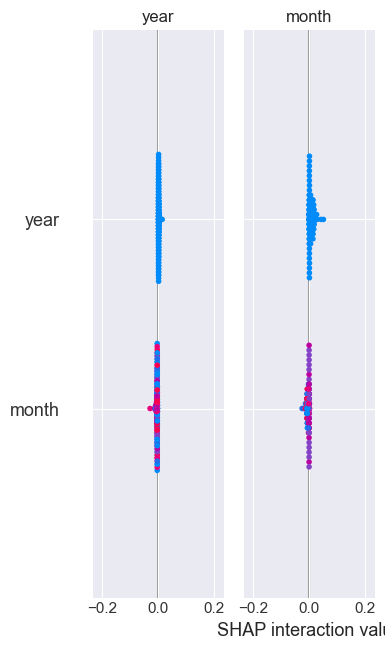

✅ SHAP analysis complete


In [61]:
# Cell 9.1: SHAP Values (Best Tree Model) - Only if SHAP available
if SHAP_AVAILABLE:
    # Select best tree-based model for SHAP
    best_tree_model = rf_bal  # Using balanced RF as example
    
    # Sample for SHAP (to speed up computation)
    sample_size = min(200, len(X_val))
    X_val_sample = X_val.sample(n=sample_size, random_state=RANDOM_SEED)
    
    try:
        explainer = shap.TreeExplainer(best_tree_model)
        shap_values = explainer.shap_values(X_val_sample)
        
        # For binary classification, get positive class SHAP values
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_val_sample, show=False, plot_type='bar')
        plt.tight_layout()
        plt.savefig(PROCESSED_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ SHAP analysis complete")
    except Exception as e:
        print(f"⚠️  SHAP error: {e}")
else:
    print("⚠️  SHAP not available, skipping SHAP analysis")


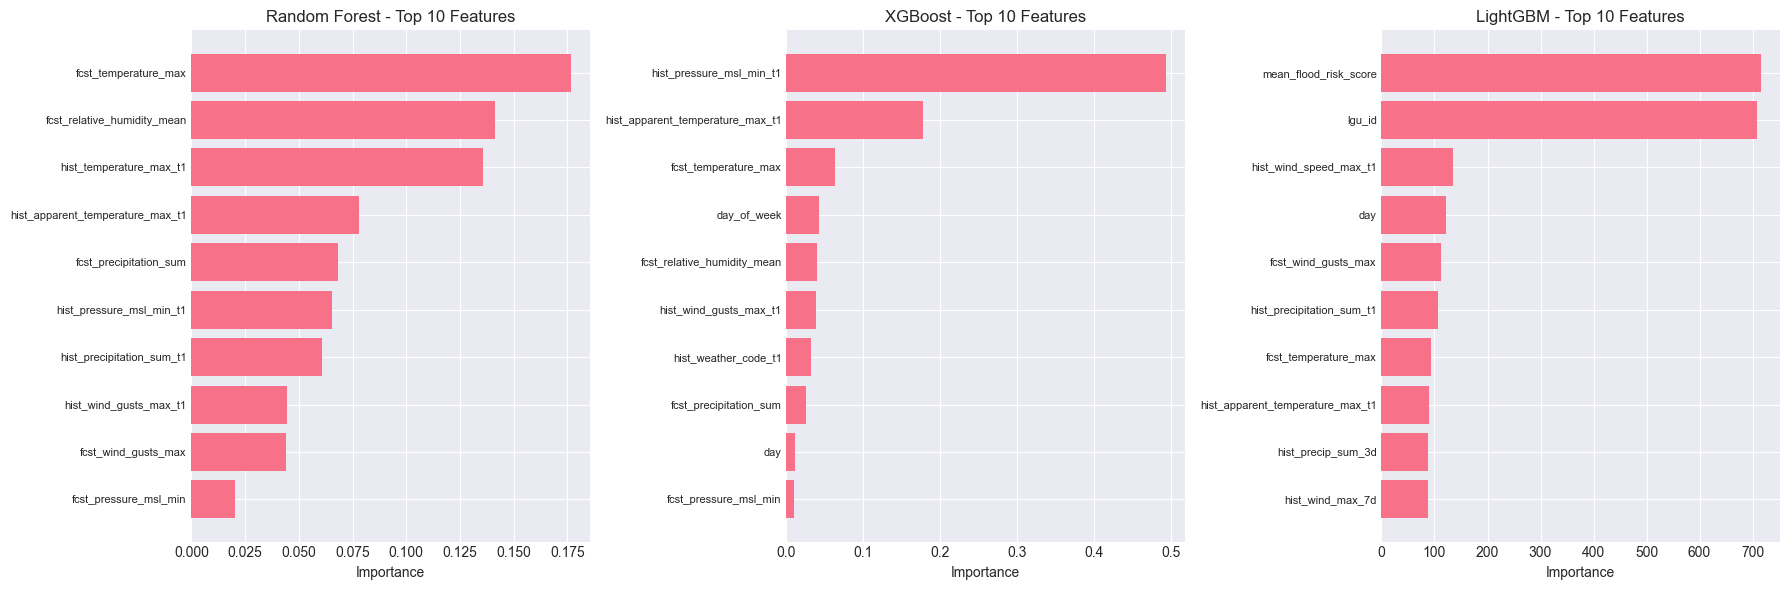

✅ Feature importance comparison complete


In [62]:
# Cell 9.2: Feature Importance Comparison
# Get feature importances from tree models
models_to_compare = ['Random Forest', 'XGBoost', 'LightGBM']
model_objects = [rf_bal, xgb_def, lgb_def]
importance_dict = {}

for name, model in zip(models_to_compare, model_objects):
    if hasattr(model, 'feature_importances_'):
        importance_dict[name] = dict(zip(final_features, model.feature_importances_))

# Plot top 10 features for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, (name, model) in enumerate(zip(models_to_compare, model_objects)):
    if name in importance_dict:
        feat_imp = pd.Series(importance_dict[name]).sort_values(ascending=False).head(10)
        axes[idx].barh(range(len(feat_imp)), feat_imp.values)
        axes[idx].set_yticks(range(len(feat_imp)))
        axes[idx].set_yticklabels(feat_imp.index, fontsize=8)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name} - Top 10 Features')
        axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Feature importance comparison complete")


⚠️  Could not plot PDP for fcst_temperature_max: name 'plot_partial_dependence' is not defined
⚠️  Could not plot PDP for fcst_relative_humidity_mean: name 'plot_partial_dependence' is not defined
⚠️  Could not plot PDP for hist_temperature_max_t1: name 'plot_partial_dependence' is not defined


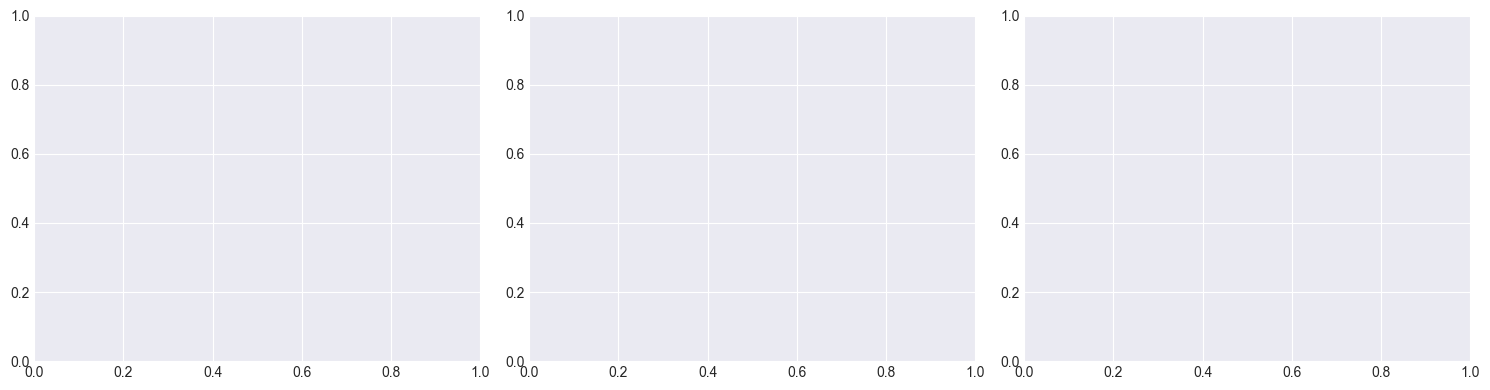

✅ Partial dependence plots complete


In [63]:
# Cell 9.3: Partial Dependence Plots (Top 3 Features)
from sklearn.inspection import PartialDependenceDisplay

# Get top feature from RF
top_feature = pd.Series(importance_dict['Random Forest']).sort_values(ascending=False).head(3).index.tolist()

fig, axes = plt.subplots(1, min(3, len(top_feature)), figsize=(5*min(3, len(top_feature)), 4))
if len(top_feature) == 1:
    axes = [axes]

for idx, feat in enumerate(top_feature[:3]):
    if feat in X_val.columns:
        try:
            plot_partial_dependence(
                rf_bal, X_val, features=[feat],
                ax=axes[idx], grid_resolution=20
            )
            axes[idx].set_title(f'PDP: {feat}')
        except Exception as e:
            print(f"⚠️  Could not plot PDP for {feat}: {e}")

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'partial_dependence_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Partial dependence plots complete")


## Section 10: Save Outputs & Handover


## Summary

Notebook 02 complete! Key outputs:
- EDA visualizations saved
- Feature selection completed
- Multiple models trained and compared
- Best model identified and saved
- Metadata and results saved

**Ready for Notebook 03: Final evaluation on test set**


In [64]:
# Cell 10.1-10.4: Save Best Model and Metadata
import joblib

# Get best model (by F2 score)
best_model_name = results_df.iloc[0]['Model']
best_model = None

# Map model names to actual models
model_map = {
    'Random Forest': rf_def, 'Random Forest Balanced': rf_bal,
    'Balanced Random Forest': brf, 'Random Forest + SMOTE': rf_smote,
    'XGBoost': xgb_def, 'XGBoost Weighted': xgb_weight, 'XGBoost + SMOTE': xgb_smote,
    'LightGBM': lgb_def, 'LightGBM Unbalanced': lgb_unbalance, 'LightGBM + SMOTE': lgb_smote
}
best_model = model_map.get(best_model_name)

if best_model:
    joblib.dump(best_model, PROCESSED_DIR / 'best_core_model.pkl')
    print(f"✅ Best model saved: {best_model_name}")

# Save metadata
metadata = {
    'best_model': best_model_name,
    'best_f2': float(results_df.iloc[0]['F2']),
    'best_recall': float(results_df.iloc[0]['Recall']),
    'best_precision': float(results_df.iloc[0]['Precision']),
    'best_threshold': 0.5,
    'train_rows': len(X_train),
    'val_rows': len(X_val),
    'train_event_rate': float(y_train.mean()),
    'val_event_rate': float(y_val.mean()),
    'final_feature_count': len(final_features),
    'selected_features': final_features
}

with open(PROCESSED_DIR / 'core_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved to core_model_metadata.json")

print("\n" + "="*60)
print("# Notebook 02 - Completed")
print("="*60)
print(f"\nSummary:")
print(f"- Trained {len(results_df)} models across multiple families")
print(f"- Best model: {best_model_name}")
print(f"- Best F2: {results_df.iloc[0]['F2']:.4f}")
print(f"- Best Recall: {results_df.iloc[0]['Recall']:.4f}")
print(f"- Best Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"\nReady for Notebook 03!")
print("Test set is UNTOUCHED - All analysis on train+val only")
print("="*60)


✅ Metadata saved to core_model_metadata.json

# Notebook 02 - Completed

Summary:
- Trained 27 models across multiple families
- Best model: Logistic Regression Balanced
- Best F2: 0.5473
- Best Recall: 0.5871
- Best Precision: 0.4307

Ready for Notebook 03!
Test set is UNTOUCHED - All analysis on train+val only
